In [ ]:
import os
import shutil

# Create the directory if it doesn't exist
directory_name = "fake videos"
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

# List of video files to move
video_files = [
    "/content/vgvqcbtepv.mp4",
    "/content/ooafcxxfrs.mp4",
    "/content/ehthgupumf.mp4",
    "/content/utdlsqfykm.mp4",
    "/content/mdfndlljvt.mp4",
    "/content/zumqqvixhu.mp4",
    "/content/fjzrvkleur.mp4",
    "/content/kvmpmhdxly.mp4"
]

# Move each file to the new directory
for file_path in video_files:
    file_name = os.path.basename(file_path)
    destination_path = os.path.join(directory_name, file_name)
    try:
        shutil.move(file_path, destination_path)
        print(f"Moved '{file_name}' to '{directory_name}'")
    except FileNotFoundError:
        print(f"File '{file_name}' not found.")
    except Exception as e:
        print(f"Error moving file '{file_name}': {e}")

print("Done moving files.")

Moved 'vgvqcbtepv.mp4' to 'fake videos'
Moved 'ooafcxxfrs.mp4' to 'fake videos'
Moved 'ehthgupumf.mp4' to 'fake videos'
Moved 'utdlsqfykm.mp4' to 'fake videos'
Moved 'mdfndlljvt.mp4' to 'fake videos'
Moved 'zumqqvixhu.mp4' to 'fake videos'
Moved 'fjzrvkleur.mp4' to 'fake videos'
Moved 'kvmpmhdxly.mp4' to 'fake videos'
Done moving files.


In [ ]:
import os
import shutil

# Create the directory if it doesn't exist
directory_name = "real videos"
if not os.path.exists(directory_name):
    os.makedirs(directory_name)

# List of video files to move
video_files = [
    "/content/wixbuuzygv.mp4",
    "/content/nymodlmxni.mp4",
    "/content/qjqxfcgsyd.mp4",
    "/content/xrhqtmxlvx.mp4",
    "/content/fpevfidstw.mp4",
    "/content/pdufsewrec.mp4",
    "/content/qjdtgggqym.mp4",
    "/content/eyguqfmgzh.mp4"
]

# Move each file to the new directory
for file_path in video_files:
    file_name = os.path.basename(file_path)
    destination_path = os.path.join(directory_name, file_name)
    try:
        shutil.move(file_path, destination_path)
        print(f"Moved '{file_name}' to '{directory_name}'")
    except FileNotFoundError:
        print(f"File '{file_name}' not found.")
    except Exception as e:
        print(f"Error moving file '{file_name}': {e}")

print("Done moving files.")

Moved 'wixbuuzygv.mp4' to 'real videos'
Moved 'nymodlmxni.mp4' to 'real videos'
Moved 'qjqxfcgsyd.mp4' to 'real videos'
Moved 'xrhqtmxlvx.mp4' to 'real videos'
Moved 'fpevfidstw.mp4' to 'real videos'
Moved 'pdufsewrec.mp4' to 'real videos'
Moved 'qjdtgggqym.mp4' to 'real videos'
Moved 'eyguqfmgzh.mp4' to 'real videos'
Done moving files.


In [ ]:
import cv2
import os


input_dirs = {
    "real": "real videos",
    "fake": "fake videos"
}

output_dirs = {
    "real": "frames/real",
    "fake": "frames/fake"
}

for folder in output_dirs.values():
    os.makedirs(folder, exist_ok=True)

FRAME_INTERVAL = 30

def extract_frames(video_path, output_folder, label, max_frames=10):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    while cap.isOpened() and saved_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        # Save every FRAME_INTERVAL
        if frame_count % FRAME_INTERVAL == 0:
            filename = f"{label}_{os.path.splitext(os.path.basename(video_path))[0]}_{saved_count}.jpg"
            save_path = os.path.join(output_folder, filename)
            cv2.imwrite(save_path, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
for label, folder in input_dirs.items():
    for video_file in os.listdir(folder):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(folder, video_file)
            extract_frames(video_path, output_dirs[label], label)

print("✅ Frame extraction complete. Check frames/real and frames/fake.")

✅ Frame extraction complete. Check frames/real and frames/fake.


In [ ]:
# Install required libraries
!pip install transformers datasets timm accelerate -q
!pip install torch torchvision -q

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTFeatureExtractor

# ==============================
# CONFIG
# ==============================
BATCH_SIZE = 8
IMG_SIZE = 224
EPOCHS = 2  # small dataset, few epochs enough
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "Adieee5/deepfake-detection-ViT-CrossTraining"

# ==============================
# DATASET
# ==============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# Directory structure:
# frames/
#   real/
#     frame1.jpg, frame2.jpg...
#   fake/
#     frame1.jpg, frame2.jpg...
train_data = datasets.ImageFolder("frames/", transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# ==============================
# MODEL
# ==============================
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.to(DEVICE)

# Freeze backbone
for param in model.vit.parameters():
    param.requires_grad = False

# Fine-tune classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

# ==============================
# TRAIN LOOP
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {total_loss:.4f} - Acc: {acc:.2f}%")

# ==============================
# SAVE MODEL
# ==============================
torch.save(model.state_dict(), "dfdc_vit_finetuned.pth")
print("✅ Training finished, model saved.")

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Epoch [1/2] - Loss: 49.9270 - Acc: 50.00%
Epoch [2/2] - Loss: 46.3717 - Acc: 50.00%
✅ Training finished, model saved.


In [ ]:
# Install required libraries
!pip install transformers datasets timm accelerate -q
!pip install torch torchvision -q

import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification

# ==============================
# CONFIG
# ==============================
BATCH_SIZE = 8
IMG_SIZE = 224
EPOCHS = 3  # 1 more epoch
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = "Adieee5/deepfake-detection-ViT-CrossTraining"

# ==============================
# DATASET + AUGMENTATION
# ==============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# Directory structure:
# frames/
#   real/
#     frame1.jpg, frame2.jpg...
#   fake/
#     frame1.jpg, frame2.jpg...
train_data = datasets.ImageFolder("frames/", transform=transform)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

# ==============================
# MODEL
# ==============================
model = ViTForImageClassification.from_pretrained(MODEL_NAME)
model.to(DEVICE)

# Freeze backbone
for param in model.vit.parameters():
    param.requires_grad = False

# Fine-tune classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

# ==============================
# TRAIN LOOP
# ==============================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LR)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {total_loss:.4f} - Acc: {acc:.2f}%")

# ==============================
# SAVE MODEL
# ==============================
torch.save(model.state_dict(), "dfdc_vit_finetuned_aug.pth")
print("✅ Training finished, model saved.")

Epoch [1/3] - Loss: 49.8445 - Acc: 50.62%
Epoch [2/3] - Loss: 45.8440 - Acc: 50.62%
Epoch [3/3] - Loss: 42.1911 - Acc: 51.25%
✅ Training finished, model saved.


In [ ]:
import cv2
import torch
from torchvision import transforms
from transformers import ViTForImageClassification
from PIL import Image

# ==============================
# CONFIG
# ==============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "dfdc_vit_finetuned_aug.pth"
IMG_SIZE = 224
FRAME_INTERVAL = 5  # process every 5th frame

# Load fine-tuned model
model = ViTForImageClassification.from_pretrained("Adieee5/deepfake-detection-ViT-CrossTraining")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Transform for frames
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# ==============================
# VIDEO INFERENCE FUNCTION
# ==============================
def predict_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_preds = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % FRAME_INTERVAL == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert NumPy array to PIL Image
            img_pil = Image.fromarray(frame_rgb)
            # Transform & add batch dimension
            img_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)
            # Predict
            with torch.no_grad():
                logits = model(img_tensor).logits
                pred = torch.argmax(logits, dim=1).item()
                frame_preds.append(pred)

        frame_count += 1

    cap.release()

    # Aggregate predictions
    real_count = frame_preds.count(0)
    fake_count = frame_preds.count(1)
    verdict = "Real" if real_count > fake_count else "Fake"
    print(f"✅ Video Verdict: {verdict} | Real frames: {real_count}, Fake frames: {fake_count}")
    return verdict

# Example usage
predict_video("/content/qjdtgggqym.mp4")

✅ Video Verdict: Fake | Real frames: 0, Fake frames: 60


'Fake'

In [ ]:
import cv2
import torch
from torchvision import transforms
from transformers import ViTForImageClassification
import numpy as np
from PIL import Image

# ==============================
# CONFIG
# ==============================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "dfdc_vit_finetuned_aug.pth"
IMG_SIZE = 224
FRAME_INTERVAL = 5  # process every 5th frame

# Load fine-tuned model
model = ViTForImageClassification.from_pretrained("Adieee5/deepfake-detection-ViT-CrossTraining")
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Transform for frames
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

# ==============================
# VIDEO INFERENCE WITH CONFIDENCE
# ==============================
def predict_video_with_confidence(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_preds = []
    frame_confidences = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % FRAME_INTERVAL == 0:
            # Convert BGR to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # Convert NumPy array to PIL Image
            img_pil = Image.fromarray(frame_rgb)
            # Transform & add batch dimension
            img_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

            # Predict
            with torch.no_grad():
                logits = model(img_tensor).logits
                probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
                pred = np.argmax(probs)
                confidence = probs[pred]

                frame_preds.append(pred)
                frame_confidences.append(confidence)

        frame_count += 1

    cap.release()

    # Aggregate video-level results
    real_confidences = [c for p,c in zip(frame_preds, frame_confidences) if p==0]
    fake_confidences = [c for p,c in zip(frame_preds, frame_confidences) if p==1]

    avg_confidence_real = np.mean(real_confidences) if real_confidences else 0
    avg_confidence_fake = np.mean(fake_confidences) if fake_confidences else 0


    verdict = "Real" if avg_confidence_real > avg_confidence_fake else "Fake"

    # Simple report
    report = {
        "video_path": video_path,
        "verdict": verdict,
        "avg_confidence_real": avg_confidence_real,
        "avg_confidence_fake": avg_confidence_fake,
        "frames_analyzed": len(frame_preds)
    }

    print(f"✅ Video Verdict: {verdict}")
    print(f"Confidence - Real: {avg_confidence_real:.2f}, Fake: {avg_confidence_fake:.2f}")
    return report

# Example usage
report = predict_video_with_confidence("/content/qjdtgggqym.mp4")

✅ Video Verdict: Fake
Confidence - Real: 0.00, Fake: 0.87


In [ ]:
# Install torchcam for XAI visualization
!pip install torchcam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 73.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


Prediction: 1
Confidence: 0.6398
Generating Grad-CAM visualization...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


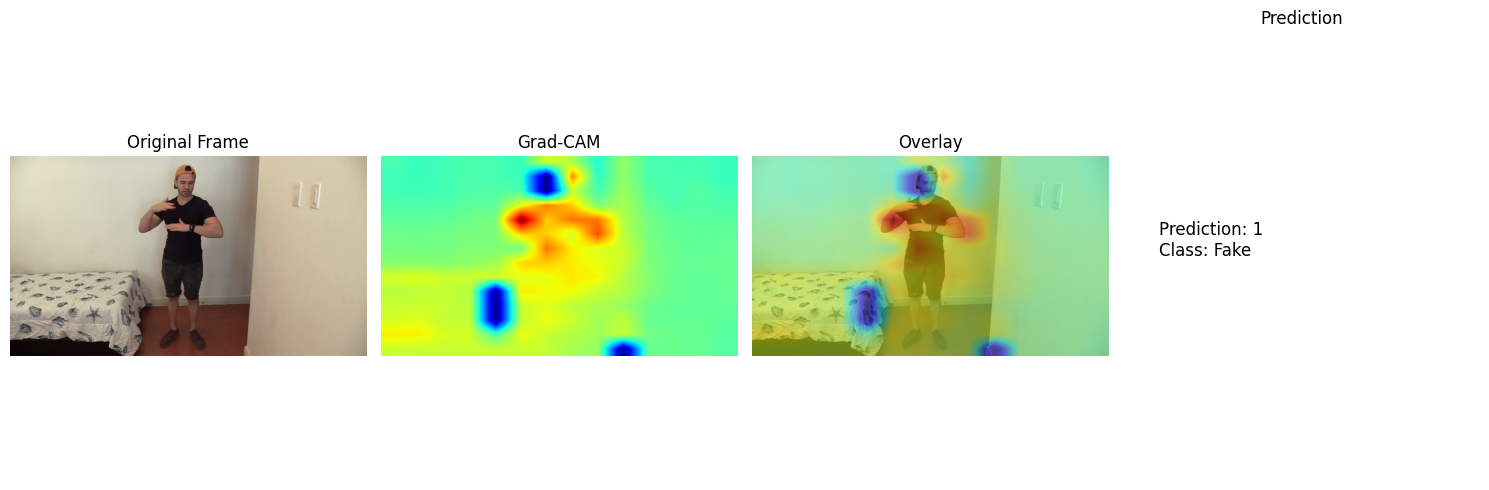

Generating Attention visualization...


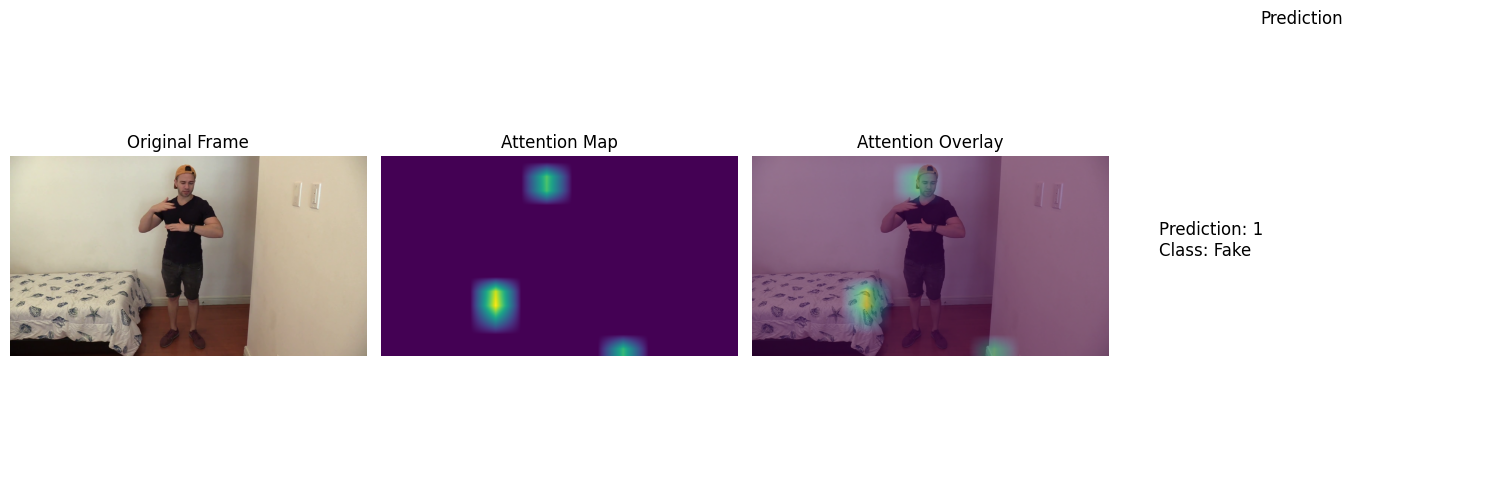

Generating Saliency visualization...


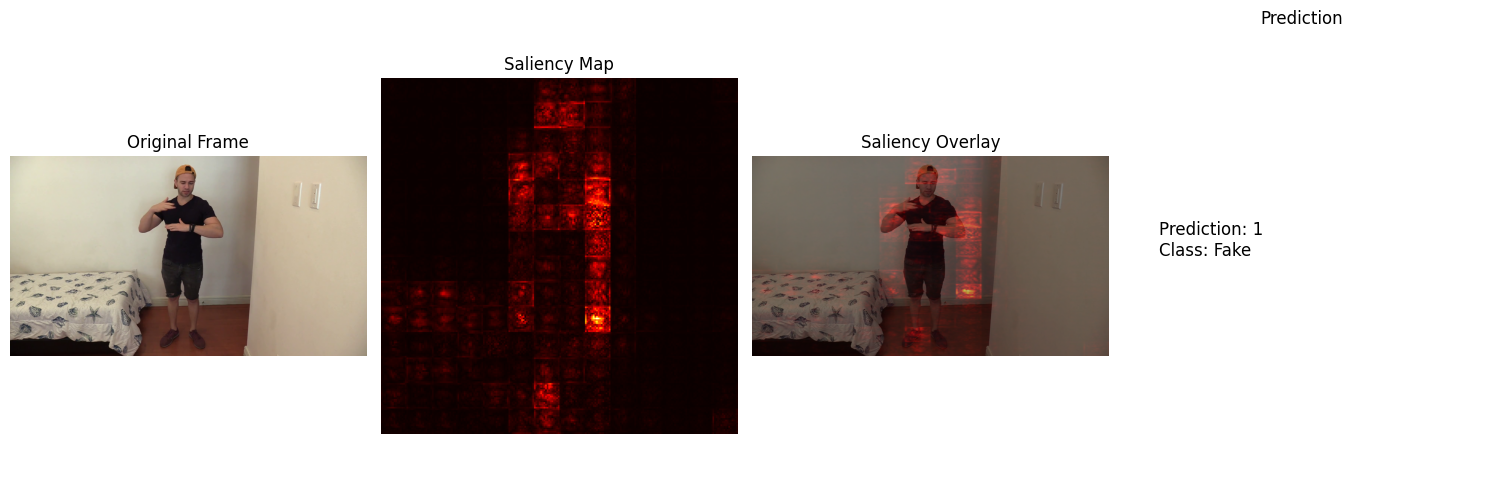

In [ ]:
import matplotlib.pyplot as plt
import cv2
import torch
from torchvision import transforms
from transformers import ViTForImageClassification
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torch import nn

# Load fine-tuned model
# Set output_attentions=True to get attention weights
model = ViTForImageClassification.from_pretrained("Adieee5/deepfake-detection-ViT-CrossTraining", return_dict=True, output_attentions=True)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Solution 1: Custom Grad-CAM implementation for ViT
class ViTGradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None

        # Hook the last layer before classification
        # For ViT, we'll hook the layer norm before the classifier
        self.hook_layers()

    def hook_layers(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        def forward_hook(module, input, output):
            self.activations = output

        # Hook the layernorm layer (last layer before classifier)
        target_layer = self.model.vit.layernorm
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output.logits, dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_score = output.logits[0, class_idx]
        class_score.backward()

        # Generate CAM
        gradients = self.gradients[0]  # Remove batch dimension
        activations = self.activations[0]  # Remove batch dimension

        # Global average pooling of gradients
        weights = torch.mean(gradients, dim=0)

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[0])
        for i, w in enumerate(weights):
            cam += w * activations[:, i]

        # Apply ReLU
        cam = F.relu(cam)

        # Reshape to spatial dimensions (14x14 for ViT-base with 224x224 input)
        patch_size = 16  # Standard ViT patch size
        num_patches = int(np.sqrt(cam.shape[0] - 1))  # -1 for CLS token

        # Remove CLS token and reshape
        cam = cam[1:].reshape(num_patches, num_patches)

        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min())

        return cam.detach().cpu().numpy()

# Solution 2: Attention Visualization for ViT
class ViTAttentionVisualizer:
    def __init__(self, model):
        self.model = model
        self.attention_maps = []

        # Hook all attention layers
        for layer in self.model.vit.encoder.layer:
            # Hook the attention output, which should contain attention weights
            layer.attention.attention.register_forward_hook(self.attention_hook)

    def attention_hook(self, module, input, output):
        # Store attention weights - usually the second element of the output tuple
        # output is (hidden_states, attention_probs) if output_attentions=True
        self.attention_maps.append(output[1])

    def visualize_attention(self, input_tensor, layer_idx=-1, head_idx=0):
        self.attention_maps = []

        with torch.no_grad():
            _ = self.model(input_tensor)

        # Get attention from specified layer
        # attention shape: (batch_size, num_heads, seq_len, seq_len)
        attention = self.attention_maps[layer_idx][0]  # Remove batch dimension

        # Get attention from CLS token to all patches (first row for the selected head)
        # cls_attention shape: (seq_len,)
        cls_attention = attention[head_idx, 0, 1:]  # Skip CLS to CLS attention

        # Reshape to spatial dimensions
        num_patches = int(np.sqrt(cls_attention.shape[0]))
        attention_map = cls_attention.reshape(num_patches, num_patches)

        # Normalize attention map
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())


        return attention_map.detach().cpu().numpy()

# Solution 3: Simple gradient-based saliency
def compute_saliency_map(model, input_tensor, class_idx=None):
    input_tensor.requires_grad_()

    output = model(input_tensor)

    if class_idx is None:
        class_idx = torch.argmax(output.logits, dim=1).item()

    class_score = output.logits[0, class_idx]
    class_score.backward()

    # Get gradients
    saliency = input_tensor.grad.data.abs()
    saliency = torch.max(saliency, dim=1)[0]  # Max across color channels

    return saliency.squeeze().cpu().numpy()

def visualize_xai_alternative(frame, img_tensor, pred_class, method='gradcam'):
    plt.figure(figsize=(15, 5))

    # Original frame
    plt.subplot(1, 4, 1)
    plt.imshow(frame)
    plt.title('Original Frame')
    plt.axis('off')

    if method == 'gradcam':
        # Custom Grad-CAM
        gradcam = ViTGradCAM(model)
        cam_map = gradcam.generate_cam(img_tensor, pred_class.item())

        plt.subplot(1, 4, 2)
        plt.imshow(cv2.resize(cam_map, (frame.shape[1], frame.shape[0])), cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(frame)
        plt.imshow(cv2.resize(cam_map, (frame.shape[1], frame.shape[0])), cmap='jet', alpha=0.5)
        plt.title('Overlay')
        plt.axis('off')

    elif method == 'attention':
        # Attention visualization
        att_viz = ViTAttentionVisualizer(model)
        att_map = att_viz.visualize_attention(img_tensor)

        plt.subplot(1, 4, 2)
        plt.imshow(cv2.resize(att_map, (frame.shape[1], frame.shape[0])), cmap='viridis')
        plt.title('Attention Map')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(frame)
        plt.imshow(cv2.resize(att_map, (frame.shape[1], frame.shape[0])), cmap='viridis', alpha=0.5)
        plt.title('Attention Overlay')
        plt.axis('off')

    elif method == 'saliency':
        # Saliency map
        saliency_map = compute_saliency_map(model, img_tensor.clone(), pred_class.item())

        plt.subplot(1, 4, 2)
        plt.imshow(saliency_map, cmap='hot')
        plt.title('Saliency Map')
        plt.axis('off')

        plt.subplot(1, 4, 3)
        plt.imshow(frame)
        plt.imshow(cv2.resize(saliency_map, (frame.shape[1], frame.shape[0])), cmap='hot', alpha=0.5)
        plt.title('Saliency Overlay')
        plt.axis('off')

    # Prediction info
    plt.subplot(1, 4, 4)
    plt.text(0.1, 0.5, f'Prediction: {pred_class.item()}\nClass: {"Real" if pred_class.item() == 0 else "Fake"}',
             fontsize=12, transform=plt.gca().transAxes)
    plt.axis('off')
    plt.title('Prediction')

    plt.tight_layout()
    plt.show()

# Transform definition
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Example usage
video_path = "/content/qjdtgggqym.mp4"
cap = cv2.VideoCapture(video_path)

if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(frame_rgb)
        img_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            outputs = model(img_tensor)
            logits = outputs.logits
            pred_class = torch.argmax(logits, dim=1)

        print(f"Prediction: {pred_class.item()}")
        print(f"Confidence: {F.softmax(logits, dim=1).max().item():.4f}")

        # Try different visualization methods
        print("Generating Grad-CAM visualization...")
        visualize_xai_alternative(frame_rgb, img_tensor, pred_class, method='gradcam')

        print("Generating Attention visualization...")
        visualize_xai_alternative(frame_rgb, img_tensor, pred_class, method='attention')

        print("Generating Saliency visualization...")
        visualize_xai_alternative(frame_rgb, img_tensor, pred_class, method='saliency')

    else:
        print(f"Could not read frame from {video_path}")
else:
    print(f"Could not open video file {video_path}")

cap.release()